# outline of 'Revealing non-canonical RNA interactions in DMS chemical mapping'

## Extra resources
current draft: https://uofnelincoln-my.sharepoint.com/:w:/r/personal/jyesselman2_unl_edu/_layouts/15/Doc.aspx?sourcedoc=%7B2AAE1849-B2EB-44FC-8A5F-1ED79D0654BC%7D&file=draft_9.docx&action=default&mobileredirect=true

# Notebook setup
NOTE: all data is assumed to be in '../data' and this notebook will not work if the data is in another location!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, pearsonr, linregress
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

from dms_3d_features.plotting import (
    plot_pop_avg_from_row,
    publication_style_ax,
    plot_motif_boxplot_stripplot,
    plot_scatter_w_best_fit_line,
    format_small_plot,
)
from dms_3d_features.pdb_features import compute_solvent_accessibility_all

## extra functions

In [2]:
def r2(x, y):
    return pearsonr(x, y)[0] ** 2

In [3]:
def generate_replicate_df(df_construct: pd.DataFrame, df_construct_2) -> pd.DataFrame:
    """
    Generates a replicate DataFrame by merging two input DataFrames based on the 'name' column.

    Args:
        df_construct (pandas.DataFrame): The first DataFrame containing the 'name' and 'data' columns.
        df_construct_2 (pandas.DataFrame): The second DataFrame containing the 'name' and 'data' columns.

    Returns:
        pandas.DataFrame: A new DataFrame with columns 'data_1' and 'data_2', where
            each row contains a pair of corresponding data values from the input DataFrames.

    Raises:
        None
    """
    df_2_sub = df_construct_2[["name", "data"]].copy()
    df_2_sub.rename(columns={"data": "data_2"}, inplace=True)
    df_merge = df_construct.merge(df_2_sub, on="name").copy()
    data = []
    for i, row in df_merge.iterrows():
        for d1, d2 in zip(row["data"], row["data_2"]):
            data.append({"data_1": d1, "data_2": d2})
    df_data = pd.DataFrame(data)
    return df_data

## load data

In [4]:
DATA_PATH = "../data"

load all the data from the data folder<br>
`df_construct` is all the data of constructs before any processing<br>
`df_construct_2` is the replicate date to compare reproduceability<br>
`df_motif` is processing all the constructs so that motifs are grouped together<br>
`df` is processed data where all resiudes have their own row<br>

In [5]:
df_construct = pd.read_json(
    f"{DATA_PATH}/raw-jsons/constructs/pdb_library_1_combined.json"
)
df_construct_2 = pd.read_json(
    f"{DATA_PATH}/raw-jsons/constructs/pdb_library_2_combined.json"
)
df_motif = pd.read_json(
    f"{DATA_PATH}/raw-jsons/motifs/pdb_library_1_motifs_standard.json"
)
df = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")

In [6]:
df["ln_r_data"] = np.log(df["r_data"])
df["ln_r_data"].replace(-np.inf, -9.8, inplace=True)

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
# TODO give explanation of each feature
df.iloc[0]

both_purine                                                         False
both_pyrimidine                                                     False
constructs                                                    construct65
has_pdbs                                                             True
likely_pair                                                              
m_flank_bp_5p                                                          AU
m_flank_bp_3p                                                          CG
m_orientation                                                     flipped
m_pos                                                                   4
m_second_flank_bp_5p                                                   GC
m_second_flank_bp_3p                                                   GC
m_sequence                                                       AAAC&GCU
m_structure                                                      (..(&).)
m_token                               

# Results

## Designing a massive RNA library to investigate the relationship between DMS reactivity and non-canonical interactions.  

Outline
1. Understanding how RNA structure relates to DMS reactivity requires probing a large set of RNA sequences with known 3d structures.<br><br>
2. To optimize the investigation of RNAs with known 3d structures, we will break them up into motifs as motifs are isolatable.<br><br>
3. Will focus on two-way junctions and which are the most common non-canonical motif and fit well into the design strategy of making long, stable hairpins<br><br>


## DMS reactivity is highly reproducible and spans five orders of magnitude. 

### Outline 

1. DMS spans five orders of magnitude and has 240,000 datapoints (Figure 1C)<br><br>
min val:  6.0e-05<br>
max val:  0.50<br>
count:  237528<br>

2. DMS reactivity is highly reproducible even at low mutation fraction (Figure 1D)<br><br>
r2 = 0.99<br>

3. <font color='green'>DMS reactivity is highly local compare to full structures **TODO**<br><br>
    a. how many residues are the within the same range as the isolated motifs<br>
    b. how many of the excluded motif had different reactivity<br>
    c. correlation plot to compare?<br>
    d. for ones that are differnt is there an explanation for why they are different<br></font>

4. Motif DMS reactivity patterns are reproducible, and the amount of error is small suggesting DMS is a mostly influenced by local structure (Figure 1F)<br><br>



### Analysis

#### statistics on number of reads per construct, average number is 38,000

In [8]:
df_construct["num_aligned"].describe()

count      7500.000000
mean      37688.644133
std       26941.748951
min         369.000000
25%       19796.750000
50%       31129.000000
75%       48240.500000
max      421216.000000
Name: num_aligned, dtype: float64

#### find highest and lowest DMS values and number of data points

In [9]:
lowest_non_zero_value = df[df["r_data"] != 0]["r_data"].min()
print("min val: ", lowest_non_zero_value)
print("max val: ", df["r_data"].max())
print("count: ", len(df))

min val:  6.000000000000001e-05
max val:  0.5006900000000001
count:  237528


#### corelation between experimental replicates

In [10]:
df_data = generate_replicate_df(df_construct, df_construct_2)
print("r2: ", r2(df_data["data_1"], df_data["data_2"]))

r2:  0.9904858197439965


#### average coefficient of variation

In [11]:
data = []
for i, group in df.groupby(["r_loc_pos", "m_sequence"]):
    data.append(group["r_data"].std() / group["r_data"].mean())
np.mean(data)

0.3942839835926987

### Figure 1

#### Figure 1B: construct to highlight diversity of structures. Find one with the most different motifs

In [12]:
def figure_1b(df_construct, ax):
    row = df_construct.iloc[7000].to_dict()
    row["sequence"] = row["sequence"][1:]
    row["structure"] = row["structure"][1:]
    row["data"] = row["data"][1:]
    ax = plot_pop_avg_from_row(row, ax=ax)
    ax.set_xlabel("Nucleotide", labelpad=2)
    ax.set_ylabel("Mutation Fraction", labelpad=2)
    ax.set_yticks([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06])
    ax.set_xlim(-1, 112)
    ax.tick_params(axis="x", which="both", bottom=False, top=False, size=-1)
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=4)

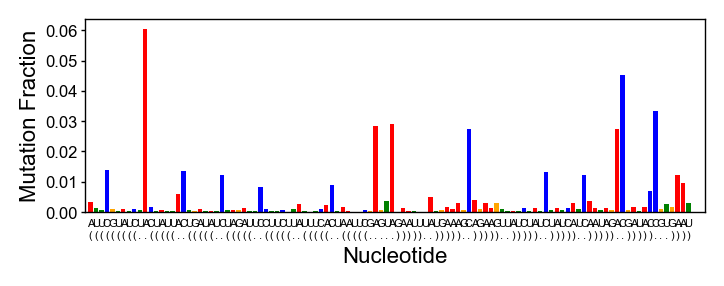

In [13]:
fig, ax = plt.subplots(figsize=(4.00, 1.25), dpi=200)
figure_1b(df_construct, ax)

#### Figure 1C: mutation fractions of DMS reactivity are highly reproducible

In [14]:
def figure_1c(df_construct, df_construct_2, ax):
    # prepare data for plot
    df_data = generate_replicate_df(df_construct, df_construct_2)
    # generate plot
    plot_scatter_w_best_fit_line(df_data["data_1"], df_data["data_2"], ax=ax)
    ax.set_xlabel("Mut. Frac. Run 1", labelpad=2)
    ax.set_ylabel("Mut. Frac. Run 2", labelpad=2)
    ax.set_xticks([0.00, 0.20, 0.40])
    ax.set_yticks([0.00, 0.20, 0.40])
    format_small_plot(ax)

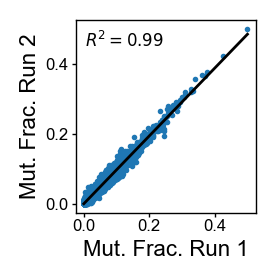

In [15]:
fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
figure_1c(df_construct, df_construct_2, ax)

#### Figure 1D: histogram of DMS reactivity in Ln space visualize the distribution over the five orders of magnitude

In [16]:
def figure_1d(df, ax):
    ax.hist(df["ln_r_data"], bins=25)
    ax.set_yscale("log")
    ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
    ax.set_ylabel("Count", labelpad=2)
    ax.set_yticks([10, 100, 1000, 10000])
    ax.set_xticks([-10, -8, -6, -4, -2, 0])
    format_small_plot(ax)

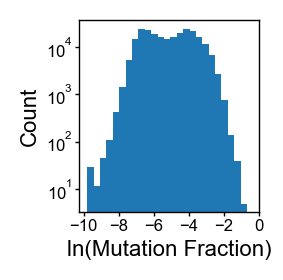

In [17]:
fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
figure_1d(df, ax)

#### Figure 1E: how often does each motif occur

In [18]:
def figure_1e(df_motif, ax):
    data = []
    for i, group in df_motif.groupby("m_sequence"):
        data.append([i, len(group)])
    df_counts = pd.DataFrame(data, columns=["m_sequence", "count"])
    ax.set_xlabel("Motif Count", labelpad=2)
    ax.set_ylabel("Count", labelpad=2)
    plt.hist(df_counts["count"], bins=100)
    format_small_plot(ax)

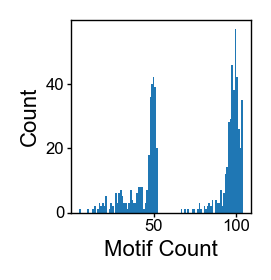

In [19]:
fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
figure_1e(df_motif, ax)

#### Figure 1F: example motif's DMS reactivity over all constructs

In [28]:
def figure_1f(df, ax):
    df_motif_example = df[df["m_sequence"] == "GGGAAAG&UAACAC"]
    df_motif_example = df_motif_example.query("r_data_outlier == False")
    plot_motif_boxplot_stripplot(df_motif_example, ax=ax)
    ax.set_xlabel("Residues", labelpad=2)
    ax.set_ylabel("Mutation Fraction", labelpad=2)
    format_small_plot(ax)

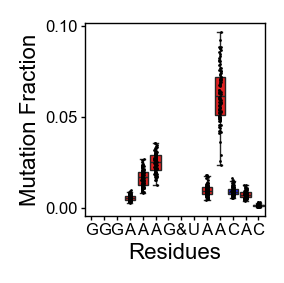

In [29]:
fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
figure_1f(df, ax)

#### Figure 1G: reactivity avg vs std

In [22]:
def figure_1g(df, ax):
    data = []
    for i, group in df.groupby(["r_loc_pos", "m_sequence"]):
        data.append([group["r_data"].mean(), group["r_data"].std()])
    df_data = pd.DataFrame(data, columns=["mean", "std"])
    plot_scatter_w_best_fit_line(np.log(df_data["mean"]), np.log(df_data["std"]), ax=ax)
    ax.set_xlabel("ln(Avg. Mut. Frac.)", labelpad=2)
    ax.set_ylabel("ln(Std. Mut. Frac.)", labelpad=2)
    ax.set_yticks([-2, -4, -6, -8])
    ax.set_xticks([-8, -6, -4, -2])
    format_small_plot(ax)

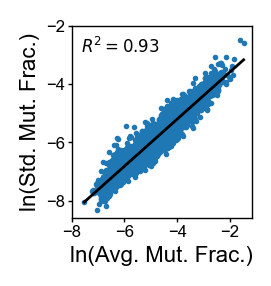

In [23]:
fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
figure_1g(df, ax)

#### Figure 1H: coefficient of variation

In [24]:
def figure_1h(df, ax):
    data = []
    for i, group in df.groupby(["r_loc_pos", "m_sequence"]):
        data.append(group["r_data"].std() / group["r_data"].mean())
    plt.hist(data, bins=50)
    format_small_plot(ax)
    ax.set_xlabel("Coefficient of Variation", labelpad=2)
    ax.set_ylabel("Count", labelpad=2)

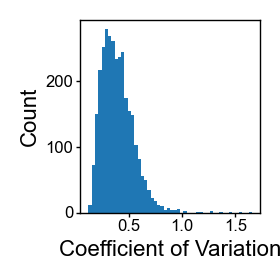

In [25]:
fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
figure_1h(df, ax)

### Supplemental Figures / Information

#### Supplemental Figure XXX: histogram of number of reads per construct

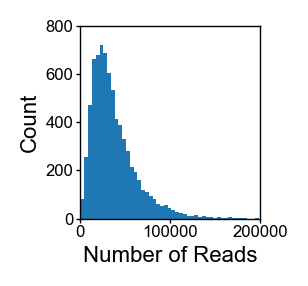

In [26]:
fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
plt.hist(df_construct["num_aligned"], bins=100)
ax.set_xlabel("Number of Reads", labelpad=2)
ax.set_ylabel("Count", labelpad=2)
ax.set_xlim([0, 200000])
ax.set_xticks([0, 100000, 200000])
ax.set_yticks(range(0, 1000, 200))
format_small_plot(ax)

#### Supplemental Figure XXX: what is the relationship between DMS reactivity and the standard deviation of DMS reactivity for a given residue

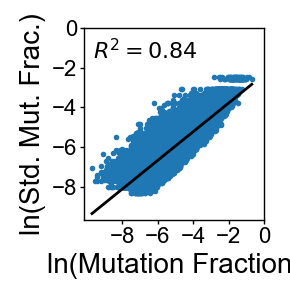

In [27]:
data = []
for i, group in df.groupby(["r_loc_pos", "m_sequence"]):
    std = group["r_data"].std()
    if std == 0:
        continue
    for _, row in group.iterrows():
        if row["r_data"] == 0:
            continue
        data.append([row["r_data"], std])
df_data = pd.DataFrame(data, columns=["r_data", "std"])
df_data["ln_r_data"] = np.log(df_data["r_data"])

fig, ax = plt.subplots(figsize=(1.5, 1.25), dpi=200)
plot_scatter_w_best_fit_line(np.log(df_data["r_data"]), np.log(df_data["std"]), ax=ax)
ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
ax.set_ylabel("ln(Std. Mut. Frac.)", labelpad=2)
ax.set_xticks([-8, -6, -4, -2, 0])
ax.set_yticks([-8, -6, -4, -2, 0])
format_small_plot(ax)
publication_style_ax(ax)

## DMS reactivity values are continuous, and a significant overlap exists between Watson-Crick and non-canonical interactions.